# **TR_2021/20 - Technical report: Poisson regression for cardiovascular deaths and extreme events**


|Technical Report ID  |2021/20|
|--|--|
| Title |Poisson regression for cardiovascular deaths and extreme events|
| Authors | Júlia De Lázari, Paula Dornhofer|
| Creation Date| 2021-09|


## Databases descriptions

**inputs:** 

- obitos_circulatorio.csv: Dataframe of deaths due to cardiovascular diseases from 2001 to 2019 (only data up to 2018 was used, to match the climate data).

- EV_VCP.csv: Dataframe with the extreme events computed. Viracopos data was used for this.

## Analysis

This report presents an analysis of the the _relative risk_ for the [extreme climate events](https://github.com/climate-and-health-datasci-Unicamp/project-climatic-variations-cardiovascular-diseases/blob/main/notebooks/TR_2020_05_Extreme_climatic_events_for_Campinas.ipynb) using a case crossover design.

##**Poisson regression**

Poisson regression was used to estimate the relative risk associated with each extreme event. The Poisson regression is used to model counts and was used to model the daily number of deaths and hospitalizations. As the mean and variance are not equal, we used a generalized Poisson regression [Consul]. In this model, the probability of observing k events is given by:

$$P_y(y=k) = \frac{e^{-(\lambda + \alpha*k)*(\lambda + \alpha*k)^{k-1}}}{k!}$$

And the mean and variance:

$$\mbox{mean(y)} = \frac{\lambda}{(1-\alpha)} \hspace{50pt} \mbox{variance(y)} = \frac{\lambda}{(1-\alpha)^3}$$

We included the other meteorological parameters, a categorical variable for the day of the week, the month, and the month and year. After an exploratory analysis of these variables and their p-value, we chose to keep the day of the week, STRATA (month and year), minimum temperature, average pressure for all the regression.

##**Import libraries**

In [1]:
#-------------------------------------------------------------------#
#                       Import libraries                            #
#-------------------------------------------------------------------#
import pandas as pd
import numpy as np
import datetime
import more_itertools as mit
import datetime
import statistics as stat
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import scipy
import seaborn as sns
sns.set()
import pylab
from datetime import timedelta
from calendar import isleap
from patsy import dmatrices
import statsmodels as stat
import statsmodels.api as sm
import statsmodels.formula.api as smf

from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Load data**

###**Climatic data**

In [2]:
#-------------------------------------------------------------------#
#                          Load Viracopos data                      #
#-------------------------------------------------------------------#

#Load humidity dataframe
df_vir = pd.read_csv('EV_VCP.csv')
df_vir = df_vir.drop(columns = {'Unnamed: 0'})
df_vir['DATE'] = pd.to_datetime(df_vir['DATE'])
df_vir['YEAR'] = df_vir['DATE'].dt.strftime('%Y') #create column for year

In [3]:
print("Percentage of null values VCP (1983-2018) \n")

print("TMIN:", round((len(df_vir[df_vir['TMIN'].isnull()]))/len(df_vir)*100,2),"%")
print("TMAX:", round((len(df_vir[df_vir['TMAX'].isnull()]))/len(df_vir)*100,2),"%")
print("AVGPRESSURE:", round((len(df_vir[df_vir['AVGPRESSURE'].isnull()]))/len(df_vir)*100,2),"%")
print("HMIN:", round((len(df_vir[df_vir['HMIN'].isnull()]))/len(df_vir)*100,2),"%")
print("HMAX:", round((len(df_vir[df_vir['HMAX'].isnull()]))/len(df_vir)*100,2),"%")

print("\n")

print("Number of null rows \n")

print("TMIN:", len(df_vir[df_vir['TMIN'].isnull()]))
print("TMAX:", len(df_vir[df_vir['TMAX'].isnull()]))
print("AVGPRESSURE:",len(df_vir[df_vir['AVGPRESSURE'].isnull()]))
print("HMIN:", len(df_vir[df_vir['HMIN'].isnull()]))
print("HMAX:", len(df_vir[df_vir['HMAX'].isnull()]))

Percentage of null values VCP (1983-2018) 

TMIN: 0.18 %
TMAX: 0.18 %
AVGPRESSURE: 0.02 %
HMIN: 0.05 %
HMAX: 0.05 %


Number of null rows 

TMIN: 12
TMAX: 12
AVGPRESSURE: 1
HMIN: 3
HMAX: 3


In [4]:
#fill na 
df_vir['HMIN'].fillna(df_vir['HMIN'].mean(), inplace=True)
df_vir['HMAX'].fillna(df_vir['HMAX'].mean(), inplace=True)
df_vir['TMIN'].fillna(df_vir['TMIN'].mean(), inplace=True)
df_vir['TMAX'].fillna(df_vir['TMAX'].mean(), inplace=True)
df_vir['AVGPRESSURE'].fillna(df_vir['AVGPRESSURE'].mean(), inplace=True)

###**Health data**

In [5]:
#-------------------------------------------------------------------#
#                      Circulatory deaths                           #
#-------------------------------------------------------------------#

df_obitos = pd.read_csv('obitos_circulatorio.csv')
df_obitos = df_obitos.drop(columns = {'Unnamed: 0','CODMUNRES','COMPLRES','CODMUNOCOR','LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII','CAUSABAS'}) #drop unneeded columns
df_obitos = df_obitos.rename(columns = {'DTOBITO':'DATE'}) #rename DTOBITO to DATE to merge dataframes
df_obitos = df_obitos[df_obitos['DATE']<='2018-12-31']
df_obitos = df_obitos[(df_obitos.DATE !='2000-02-29')&(df_obitos.DATE !='2004-02-29')&(df_obitos.DATE !='2008-02-29')&(df_obitos.DATE !='2012-02-29')&(df_obitos.DATE !='2016-02-29')] #remove leap year dates (02-29)
df_obitos = df_obitos.sort_values('DATE')

##**Merge dataframes**

In [ ]:
#use an auxiliar dataframe to store the number of deaths per day
df_aux = pd.DataFrame() #create new dataframe
df_aux['DATE'] = df_obitos['DATE']
df_aux['DEATHS'] = np.where(df_obitos['CID'].isnull(),0,df_obitos.groupby(['DATE']).DATE.transform('count'))
df_aux = df_aux.drop_duplicates('DATE',keep='first')
df_aux['DATE'] = pd.to_datetime(df_aux['DATE'])
df_aux = df_aux.sort_values('DATE')

df = pd.merge(df_aux, df_vir, on = 'DATE', how='outer')
df = df.sort_values('DATE')

,DATE,DEATHS
39408,2001-01-01,13
38864,2001-01-02,9
39420,2001-01-03,8
39425,2001-01-04,3
39426,2001-01-05,5
...,...,...
34678,2018-12-27,11
34615,2018-12-28,9
34623,2018-12-29,9
34634,2018-12-30,8


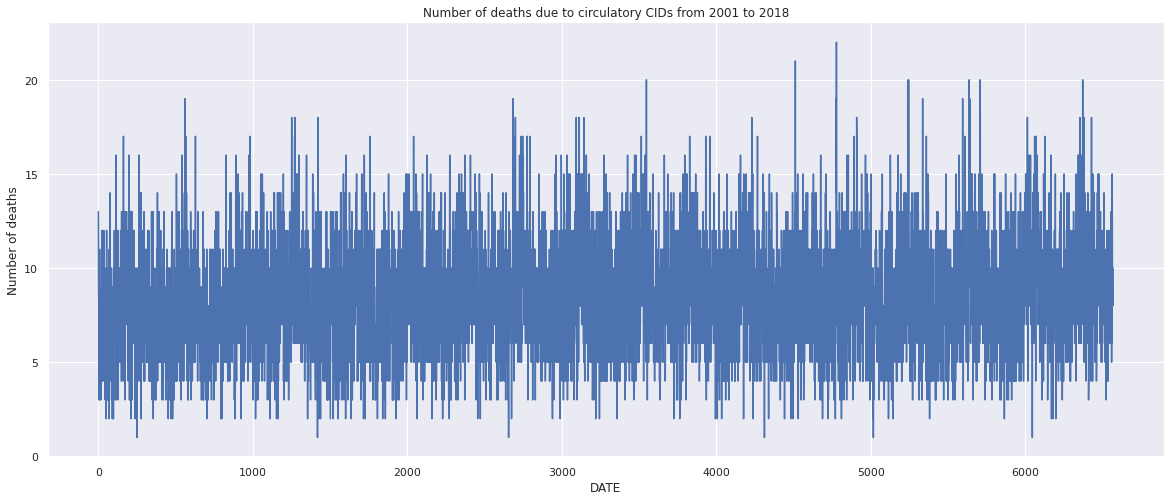

In [ ]:
#Basic plot of number of deaths
plt.figure(figsize=(20,8))
df.DEATHS.plot()
plt.title('Number of deaths due to circulatory CIDs from 2001 to 2018')
plt.ylabel('Number of deaths')
plt.xlabel('DATE')
plt.show()

In [ ]:
# data is overdispersed: variance is greater than the mean
print('variance = '+str(df['DEATHS'].var()))
print('mean = '+str(df['DEATHS'].mean()))

variance = 9.219306007578266
mean = 8.393270401948843


In [ ]:
# add derived regression variables: month, day of week and strata
df = df.set_index('DATE')
ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY_OF_WEEK'] = ds.dt.dayofweek
df['STRATA'] = ds.dt.strftime('%Y-%m')
df['STRATA'] = df['STRATA'].astype("category").astype('category').cat.codes

,DEATHS,TMIN,TMAX,AVGPRESSURE,HMIN,HMAX,T_RANGE,H_RANGE,above_temp_range,above_temp_dif,above_pressure_dif,LPW,HPW,above_humidity_range,above_humidity_dif,LHW,HHW,YEAR,MONTH,DAY_OF_WEEK,DAY,STRATA
DATE,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,13.0,17.8,27.9,938.502083,57.0,91.0,10.1,34.0,0,0,0,0,0,0,0,0,0,2001,1,0,1,0
2001-01-02,9.0,16.6,29.8,938.752083,44.0,93.0,13.2,49.0,1,0,0,0,0,0,0,0,0,2001,1,1,2,0
2001-01-03,8.0,17.3,29.6,939.866667,46.0,94.0,12.3,48.0,0,0,0,0,0,0,0,0,0,2001,1,2,3,0
2001-01-04,3.0,17.8,30.0,942.220408,51.0,98.0,12.2,47.0,0,0,1,0,0,0,0,0,0,2001,1,3,4,0
2001-01-05,5.0,17.5,31.1,941.573469,47.0,99.0,13.6,52.0,1,0,0,0,0,0,0,0,0,2001,1,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,11.0,18.4,31.2,936.183333,36.0,86.0,12.8,50.0,0,0,0,0,0,0,0,0,0,2018,12,3,27,215
2018-12-28,9.0,18.9,31.5,936.104167,40.0,88.0,12.6,48.0,0,0,0,0,0,0,0,0,0,2018,12,4,28,215
2018-12-29,9.0,18.7,32.1,935.641667,31.0,86.0,13.4,55.0,1,0,0,0,0,0,0,0,0,2018,12,5,29,215


#**Generalized Poisson Regression Deaths**

##**Temperature**

In [ ]:
#set the regression expression in patsy notation

expr = """DEATHS ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +above_temp_range"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.492423
         Iterations: 33
         Function evaluations: 39
         Gradient evaluations: 39


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 DEATHS   No. Observations:                 6568
Model:             GeneralizedPoisson   Df Residuals:                     6562
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.008417
Time:                        14:07:50   Log-Likelihood:                -16370.
converged:                       True   LL-Null:                       -16509.
Covariance Type:            nonrobust   LLR p-value:                 5.611e-58
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.9279      1.634     -2.404      0.016      -7.130      -0.726
DAY_OF_WEEK         -0.0091      0.002     -4.173      0.000      -0.013      -0.005
STRATA               0.0007   7.04e-05      9.403      0.000       0.001       0.001
TMIN                -0.0128      0.002     -7.259      0.000      -0.016      -0.009
AVGPRESSURE          0.0066      0.002      3.853      0.000       0.003       0.010
above_temp_range    -0.0049      0.015     -0.327      0.744      -0.034       0.025
alpha                0.0031      0.001      2.866      0.004       0.001       0.005
====================================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.019685,0.483883,0.000801
DAY_OF_WEEK,0.990924,0.995177,0.986690
STRATA,1.000662,1.000800,1.000524
TMIN,0.987327,0.990733,0.983933
AVGPRESSURE,1.006637,1.010030,1.003256
above_temp_range,0.995088,1.024916,0.966128
alpha,1.003060,1.005159,1.000966


In [ ]:
#set the regression expression in patsy notation

expr = """DEATHS ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +above_temp_dif"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.491282
         Iterations: 40
         Function evaluations: 46
         Gradient evaluations: 46


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 DEATHS   No. Observations:                 6568
Model:             GeneralizedPoisson   Df Residuals:                     6562
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.008871
Time:                        14:07:50   Log-Likelihood:                -16363.
converged:                       True   LL-Null:                       -16509.
Covariance Type:            nonrobust   LLR p-value:                 3.382e-61
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.6899      1.602     -2.303      0.021      -6.830      -0.550
DAY_OF_WEEK       -0.0092      0.002     -4.225      0.000      -0.013      -0.005
STRATA             0.0007   7.03e-05      9.396      0.000       0.001       0.001
TMIN              -0.0133      0.002     -7.779      0.000      -0.017      -0.010
AVGPRESSURE        0.0064      0.002      3.785      0.000       0.003       0.010
above_temp_dif    -0.1567      0.041     -3.799      0.000      -0.238      -0.076
alpha              0.0029      0.001      2.734      0.006       0.001       0.005
==================================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.024976,0.576903,0.001081
DAY_OF_WEEK,0.990823,0.995070,0.986594
STRATA,1.000661,1.000799,1.000523
TMIN,0.986746,0.990068,0.983434
AVGPRESSURE,1.006395,1.009723,1.003078
above_temp_dif,0.854951,0.926945,0.788549
alpha,1.002915,1.005010,1.000825


##**Pressure**

In [ ]:
#set the regression expression in patsy notation

expr = """DEATHS ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +LPW"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.492302
         Iterations: 36
         Function evaluations: 42
         Gradient evaluations: 42


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 DEATHS   No. Observations:                 6568
Model:             GeneralizedPoisson   Df Residuals:                     6562
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.008465
Time:                        14:07:51   Log-Likelihood:                -16369.
converged:                       True   LL-Null:                       -16509.
Covariance Type:            nonrobust   LLR p-value:                 2.565e-58
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.7867      1.703     -2.811      0.005      -8.124      -1.449
DAY_OF_WEEK    -0.0091      0.002     -4.178      0.000      -0.013      -0.005
STRATA          0.0007   7.04e-05      9.416      0.000       0.001       0.001
TMIN           -0.0122      0.002     -7.037      0.000      -0.016      -0.009
AVGPRESSURE     0.0075      0.002      4.198      0.000       0.004       0.011
LPW             0.0315      0.024      1.304      0.192      -0.016       0.079
alpha           0.0030      0.001      2.852      0.004       0.001       0.005
===============================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.008340,0.234736,0.000296
DAY_OF_WEEK,0.990915,0.995166,0.986681
STRATA,1.000663,1.000801,1.000525
TMIN,0.987862,0.991228,0.984507
AVGPRESSURE,1.007545,1.011087,1.004016
LPW,1.032021,1.082087,0.984272
alpha,1.003045,1.005143,1.000952


In [ ]:
#set the regression expression in patsy notation

expr = """DEATHS ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +HPW"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.491905
         Iterations: 17
         Function evaluations: 22
         Gradient evaluations: 22


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 DEATHS   No. Observations:                 6568
Model:             GeneralizedPoisson   Df Residuals:                     6562
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.008623
Time:                        14:07:51   Log-Likelihood:                -16367.
converged:                       True   LL-Null:                       -16509.
Covariance Type:            nonrobust   LLR p-value:                 1.943e-59
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.5693      1.705     -3.266      0.001      -8.912      -2.227
DAY_OF_WEEK    -0.0090      0.002     -4.133      0.000      -0.013      -0.005
STRATA          0.0007   7.04e-05      9.482      0.000       0.001       0.001
TMIN           -0.0119      0.002     -6.874      0.000      -0.015      -0.008
AVGPRESSURE     0.0083      0.002      4.653      0.000       0.005       0.012
HPW            -0.0509      0.019     -2.615      0.009      -0.089      -0.013
alpha           0.0030      0.001      2.818      0.005       0.001       0.005
===============================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.003813,0.107848,0.000135
DAY_OF_WEEK,0.991013,0.995265,0.986780
STRATA,1.000668,1.000806,1.000530
TMIN,0.988183,0.991538,0.984839
AVGPRESSURE,1.008382,1.011934,1.004842
HPW,0.950334,0.987325,0.914728
alpha,1.003007,1.005104,1.000914


In [ ]:
#set the regression expression in patsy notation

expr = """DEATHS ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +above_pressure_dif"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.492376
         Iterations: 34
         Function evaluations: 40
         Gradient evaluations: 40


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 DEATHS   No. Observations:                 6568
Model:             GeneralizedPoisson   Df Residuals:                     6562
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.008435
Time:                        14:07:52   Log-Likelihood:                -16370.
converged:                       True   LL-Null:                       -16509.
Covariance Type:            nonrobust   LLR p-value:                 4.156e-58
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.9227      1.607     -2.441      0.015      -7.073      -0.773
DAY_OF_WEEK           -0.0091      0.002     -4.175      0.000      -0.013      -0.005
STRATA                 0.0007   7.04e-05      9.419      0.000       0.001       0.001
TMIN                  -0.0128      0.002     -7.438      0.000      -0.016      -0.009
AVGPRESSURE            0.0066      0.002      3.912      0.000       0.003       0.010
above_pressure_dif    -0.0128      0.015     -0.844      0.399      -0.042       0.017
alpha                  0.0030      0.001      2.859      0.004       0.001       0.005
======================================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.019788,0.461772,0.000848
DAY_OF_WEEK,0.990921,0.995173,0.986688
STRATA,1.000663,1.000802,1.000525
TMIN,0.987318,0.990644,0.984003
AVGPRESSURE,1.006632,1.009972,1.003304
above_pressure_dif,0.987305,1.017050,0.958430
alpha,1.003053,1.005151,1.000959


##**Humidity**

In [ ]:
#set the regression expression in patsy notation

expr = """DEATHS ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +LHW"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.492056
         Iterations: 36
         Function evaluations: 43
         Gradient evaluations: 43


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 DEATHS   No. Observations:                 6568
Model:             GeneralizedPoisson   Df Residuals:                     6562
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.008563
Time:                        14:07:52   Log-Likelihood:                -16368.
converged:                       True   LL-Null:                       -16509.
Covariance Type:            nonrobust   LLR p-value:                 5.176e-59
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.8269      1.604     -2.386      0.017      -6.971      -0.683
DAY_OF_WEEK    -0.0092      0.002     -4.196      0.000      -0.013      -0.005
STRATA          0.0006    7.1e-05      9.027      0.000       0.001       0.001
TMIN           -0.0129      0.002     -7.530      0.000      -0.016      -0.010
AVGPRESSURE     0.0065      0.002      3.860      0.000       0.003       0.010
LHW             0.0603      0.027      2.237      0.025       0.007       0.113
alpha           0.0030      0.001      2.828      0.005       0.001       0.005
===============================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.021776,0.505067,0.000939
DAY_OF_WEEK,0.990879,0.995129,0.986647
STRATA,1.000641,1.000781,1.000502
TMIN,0.987209,0.990523,0.983907
AVGPRESSURE,1.006532,1.009864,1.003210
LHW,1.062196,1.119850,1.007511
alpha,1.003019,1.005116,1.000926


In [ ]:
#set the regression expression in patsy notation

expr = """DEATHS ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +HHW"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.492418
         Iterations: 38
         Function evaluations: 44
         Gradient evaluations: 44


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 DEATHS   No. Observations:                 6568
Model:             GeneralizedPoisson   Df Residuals:                     6562
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.008419
Time:                        14:07:53   Log-Likelihood:                -16370.
converged:                       True   LL-Null:                       -16509.
Covariance Type:            nonrobust   LLR p-value:                 5.446e-58
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.0429      1.602     -2.524      0.012      -7.182      -0.903
DAY_OF_WEEK    -0.0091      0.002     -4.168      0.000      -0.013      -0.005
STRATA          0.0007   7.05e-05      9.414      0.000       0.001       0.001
TMIN           -0.0126      0.002     -7.385      0.000      -0.016      -0.009
AVGPRESSURE     0.0067      0.002      3.998      0.000       0.003       0.010
HHW             0.0120      0.029      0.409      0.682      -0.045       0.069
alpha           0.0031      0.001      2.864      0.004       0.001       0.005
===============================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.017547,0.405235,0.000760
DAY_OF_WEEK,0.990935,0.995187,0.986701
STRATA,1.000664,1.000802,1.000526
TMIN,0.987471,0.990781,0.984172
AVGPRESSURE,1.006757,1.010086,1.003439
HHW,1.012082,1.071970,0.955539
alpha,1.003059,1.005157,1.000965


In [ ]:
#set the regression expression in patsy notation

expr = """DEATHS ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE + above_humidity_range"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.492325
         Iterations: 13
         Function evaluations: 20
         Gradient evaluations: 20


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 DEATHS   No. Observations:                 6568
Model:             GeneralizedPoisson   Df Residuals:                     6562
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.008456
Time:                        14:07:53   Log-Likelihood:                -16370.
converged:                       True   LL-Null:                       -16509.
Covariance Type:            nonrobust   LLR p-value:                 2.969e-58
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.1907      1.607     -2.609      0.009      -7.340      -1.042
DAY_OF_WEEK             -0.0091      0.002     -4.176      0.000      -0.013      -0.005
STRATA                   0.0007   7.04e-05      9.411      0.000       0.001       0.001
TMIN                    -0.0124      0.002     -7.231      0.000      -0.016      -0.009
AVGPRESSURE              0.0069      0.002      4.077      0.000       0.004       0.010
above_humidity_range     0.0149      0.013      1.183      0.237      -0.010       0.040
alpha                    0.0030      0.001      2.856      0.004       0.001       0.005
========================================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.015135,0.352773,0.000649
DAY_OF_WEEK,0.990920,0.995171,0.986686
STRATA,1.000663,1.000801,1.000525
TMIN,0.987672,0.990998,0.984356
AVGPRESSURE,1.006910,1.010248,1.003582
above_humidity_range,1.015019,1.040405,0.990252
alpha,1.003049,1.005147,1.000955


In [ ]:
#set the regression expression in patsy notation

expr = """DEATHS ~ DAY_OF_WEEK + STRATA + TMIN + AVGPRESSURE +above_humidity_dif"""
#set X and y matrices 

y, X = dmatrices(expr, df, return_type='dataframe')

#Build Famoye's Restricted Generalized Poison regression model, know as GP-2
gen_poisson_gp2 = sm.GeneralizedPoisson(y, X, p=2)

#Fit the model
gen_poisson_gp2_results = gen_poisson_gp2.fit(maxiter=5000)

#summary
gen_poisson_gp2_results.summary()

Optimization terminated successfully.
         Current function value: 2.492429
         Iterations: 38
         Function evaluations: 44
         Gradient evaluations: 44


<class 'statsmodels.iolib.summary.Summary'>
"""
                    GeneralizedPoisson Regression Results                     
==============================================================================
Dep. Variable:                 DEATHS   No. Observations:                 6568
Model:             GeneralizedPoisson   Df Residuals:                     6562
Method:                           MLE   Df Model:                            5
Date:                Thu, 28 Oct 2021   Pseudo R-squ.:                0.008414
Time:                        14:07:53   Log-Likelihood:                -16370.
converged:                       True   LL-Null:                       -16509.
Covariance Type:            nonrobust   LLR p-value:                 5.834e-58
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.0413      1.602     -2.522      0.012      -7.182      -0.901
DAY_OF_WEEK           -0.0091      0.002     -4.172      0.000      -0.013      -0.005
STRATA                 0.0007   7.04e-05      9.407      0.000       0.001       0.001
TMIN                  -0.0126      0.002     -7.391      0.000      -0.016      -0.009
AVGPRESSURE            0.0067      0.002      3.996      0.000       0.003       0.010
above_humidity_dif     0.0068      0.040      0.168      0.867      -0.072       0.086
alpha                  0.0031      0.001      2.866      0.004       0.001       0.005
======================================================================================
"""

In [ ]:
#Table with the coeficients and confidence intervals
coef = pd.DataFrame(columns ={'coef','lower ci','upper ci'})
coef['coef'] = np.exp(gen_poisson_gp2_results.params)
coef['lower ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,0])
coef['upper ci'] = np.exp(gen_poisson_gp2_results.conf_int().iloc[:,1])
coef

,coef,upper ci,lower ci
Intercept,0.017575,0.406329,0.000760
DAY_OF_WEEK,0.990928,0.995180,0.986694
STRATA,1.000663,1.000801,1.000524
TMIN,0.987462,0.990772,0.984164
AVGPRESSURE,1.006756,1.010086,1.003436
above_humidity_dif,1.006793,1.089620,0.930263
alpha,1.003061,1.005159,1.000967


#**References**

P. C. Consul,Generalized Poisson distributions: properties and applications.  M. Dekker, 1989.